In [19]:
import numpy as np
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
filename     = 'DQ Tau.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))
JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD

oneError = np.array([3.93, 3.61, 7.72, 3.56, 3.35, 3.23, 4.56, 5.11, 4.96, 4.46, 3.19, 5.66, 5.28, 3.15, 6.15,
                     2.92, 3.01, 2.92, 3.12, 3.31, 3.35, 3.27, 3.41, 3.41, 4.17, 4.56, 4.56, 3.08, 3.08, 4.82,
                     3.95, 3.95, 3.95])

twoError = np.array([2.53, 2.32, 4.97, 2.29, 2.16, 2.08, 2.94, 3.29, 3.19, 2.87, 2.06, 3.64, 3.40, 2.02, 3.96,
                     1.88, 1.94, 1.88, 2.00, 2.13, 2.16, 2.10, 2.19, 2.19, 2.69, 2.94, 2.94, 1.98, 1.98, 3.10,
                     3.41, 3.41, 3.41])

In [20]:
#the below cell converts the time of a measurement into the phase of a measurement, from known T and P
#needed before the plot is made, but cannot be done until parameter fit is foun

def phases(P, T, times):
    phased_Times = np.array([])
    for i in range(0, len(times)):
        phased_Times = np.append(phased_Times, ((times[i])-T)/P-int(((times[i])-T)/P))
        if phased_Times[i] < 0:
            phased_Times[i] = phased_Times[i]+1
    return phased_Times

In [21]:
#This cell is a python clone of the relevant portion of helio_RV.pro from the NASA IDL Library
#It is an implementation of of a procedure described in 'Double Stars' by Wulff D. Heintz

def RV(parameters): #function generates RV values plot from given parameters
    K1, P, T = parameters[0], parameters[1], parameters[2]
    e, w, y, t   = parameters[3], parameters[4], parameters[5], parameters[6]
    # t is some value of time, ultimately the independent variable, can bea single value or an array
    M = (2*np.pi/P)*(t) #Mean Anomaly is a function of time
    E1 = M + e*np.sin(M) + ((e**2)*np.sin(2*M)/2) #Eccentric Anomaly is a function of Mean Anomaly
    while True: #iteratively refines estimate of E1 from initial estimate
        E0 = E1
        M0 = E0 - e*np.sin(E0)
        E1 = E0 +(M-M0)/(1-e*np.cos(E0))
        if np.amax(E1-E0) < 1E-9:
            break
    nu = 2*np.arctan(np.sqrt((1 + e)/(1 - e))*np.tan(E1/2)) #True Anomaly is a function of Eccentric anomaly
    p, s = (K1*(np.cos(nu+w) + (e*np.cos(w)))+y), ((-K1/mass_ratio)*(np.cos(nu+w) + (e*np.cos(w)))+y)
    return p, s

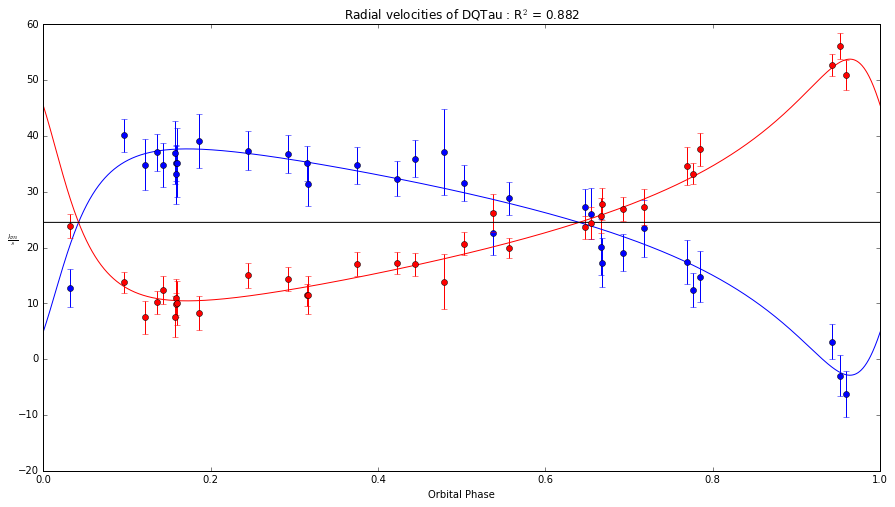

In [22]:
Period = 15.80158 #period in days determined first via periodogram
T = 47433.507 #Time offset in days, boils down to a horizontal shift in RV. T is the 'zero' point
e = 0.568 #eccentricity (unitless)
w = 4.047 #longitude of periastron in radians
y = 24.52 #systemic velocity in km/s
t = np.linspace(0, P, num = 10000)

K1= 20.28 #semamplitude in km/s
mass_ratio = 0.9363

parameters = K1, Period, T, e, w, y, t

primary, secondary = RV(parameters)
plt.figure(figsize=(15,8))
plt.plot(t/Period, primary)
plt.plot(t/Period, secondary, 'r')
plt.plot(t/Period, y*np.ones(t.size), 'k')
plt.errorbar(phases(Period, T, JD), RVp, yerr = oneError, fmt = 'bo')
plt.errorbar(phases(Period, T, JD), RVs, yerr = twoError, fmt = 'ro')
#plt.plot(phases(P, T, HJD), DQTau2, 'ro')
#plt.plot(phases(T, HJD)*P, rv(K1, P, T, e, w, y, phases(T, HJD)*P), 'bo')
#plt.plot(phases(T, HJD)*P, rv(K2, P, T, e, w, y, phases(T, HJD)*P), 'mo')
plt.xlabel('Orbital Phase')
plt.ylabel('$\\frac{km}{s}$', rotation = 0)
plt.xlim(0,1)
plt.title('Radial velocities of DQTau : R$^2$ = 0.882')
plt.savefig('DQTauRVs.png')

In [24]:
def RSquared(data1, data2, fit1, fit2): #returns r squared when given an array of observed an expected values
    def average(data):
        return sum(data)/len(data)
    R2 = 1-(sum((data1-fit1)**2)+sum((data2-fit2)**2))/(sum((data1-average(data1))**2)+sum(data2-average(data2))**2)
    return R2

#The calculation line has extra sum calls to prevent dimension mismatch errors between the RV data from a system

Period = 15.80158 #period in days determined first via periodogram
T = 47433.507 #Time offset in days, boils down to a horizontal shift in RV. T is the 'zero' point
e = 0.568 #eccentricity (unitless)
w = 4.047 #longitude of periastron in radians
y = 24.52 #systemic velocity in km/s
t = phases(Period, T, JD)*P

K1= 20.28 #semamplitude in km/s
mass_ratio = 0.9363

parameters = K1, Period, T, e, w, y, t
primary, secondary = RV(parameters)

RSquared(RVp, RVs, primary, secondary)

0.88198462337059158